# CartPole with DDQN
---

In [1]:
import gym
from gym.core import ObservationWrapper

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from IPython.display import Video

/home/hyunseok.hwang/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env = gym.make('CartPole-v1')
env._max_episode_steps=2000

The key you just pressed is not recognized by SDL. To help get this fixed, please report this to the SDL forums/mailing list <https://discourse.libsdl.org/> X11 KeyCode 208 (200), X11 KeySym 0x0 ((null)).


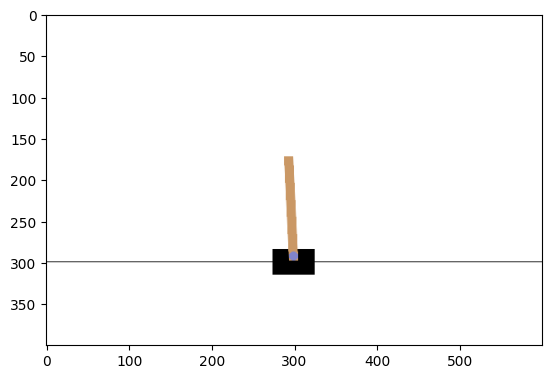

In [3]:
env.reset()
plt.imshow(env.render('rgb_array'))

## 방법1. 단순 State

In [4]:
class DQN_SimpleAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=1):
        super(DQN_SimpleAgent,self).__init__()
        self.epsilon = epsilon # Epsilon-decay를 진행할예정
        self.n_actions = n_actions
        self.state_shape = state_shape
    
        # 에이전트 인공신경망 디자인
        # 입력층 [batch,4] -> s(상태)
        # 입력 은닉층 출력층: 4, (64,32) , 2
        # 활성화 함수: 모두 relu
        #  64,32
        # 출력층 [batch,2] -> Q(s,a_왼쪽), Q(s,a_오른쪽)
        self.seq = nn.Sequential(
            nn.Linear(state_shape[-1],32),  # [batch,4] -> [batch, 64] 은닉 1층
            nn.ReLU(),
            nn.Linear(32,32), # [batch,64] -> [batch,32] 은닉 2층
            nn.ReLU(),
            nn.Linear(32,n_actions),  # [batch,32] -> [batch,2] 출력층
            nn.ReLU()         
        )
        
    def forward(self, state_t):
        '''
        Forward 함수(인공신경망 입.출력 함수)
            입력: state
            출력: Q(s,a)
        '''    
        qvalues = self.seq(state_t)
        return qvalues

    def get_actions(self, qvalues):
        '''
        [batch,action] 형태의 Q함수, epsilon값을 기준으로 Exploration vs Exploitation
        입력: 
            Q-함수, [batch, action]
        출력:
            최적행동, [batch]
        '''
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        
        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        return np.where(should_explore, random_actions, best_actions)    

Text(0.5, 1.0, 'Epsilon-decay curve')

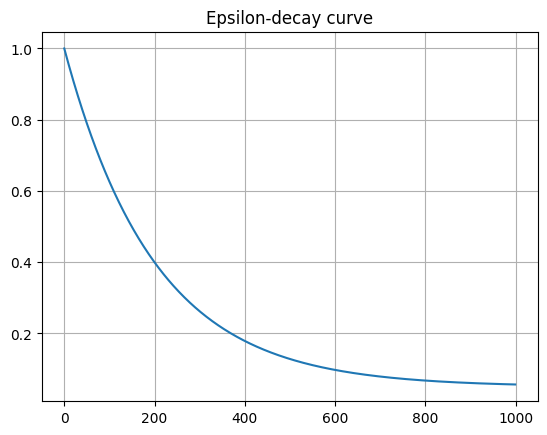

In [5]:
def epsilon_decay(t,eps_max=1,eps_min=0.05,eps_decay=200):
    return eps_min+(eps_max-eps_min)*np.exp(-1*t/eps_decay)

ts = np.arange(1000)

epsilon = []
for t in ts:
    eps = epsilon_decay(t)
    epsilon.append(eps)
plt.plot(epsilon)
plt.grid()
plt.title('Epsilon-decay curve')

In [6]:
# 리플레이 버퍼 
# https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py 에서 핵심 아이디어 채용
class ReplayBuffer(object):
    def __init__(self,size):
        '''
        리플레이 버퍼 초기 설정
        입력: 
            size - 리플레이 버퍼의 크기. 버퍼크기를 넘어가면 선입선출로 이전데이터를 메모리상에서 없앰
        '''
        self._storage = []
        self._maxsize = size
        self._next_idx = 0
        
    def __len__(self):
        return len(self._storage)
    
    def add(self,obs_t,action,reward,obs_tp,done):
        '''
        리플레이 버퍼에 데이터 추가
        입력:
            obs_t - 현재관찰(상태)
            action - 현재액션
            reward - 보상
            obs_tp - 다음관찰(상태')
            done - 종료여부
        '''
        data = (obs_t,action,reward,obs_tp,done)
        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = int((self._next_idx + 1) % self._maxsize)
        
    def _encode_sample(self,idxes):
        '''
        리플레이 버퍼로부터 샘플링
        입력:
            idxes - 메모리에서 추출할 데이터 인덱스 [batch]
        출력:
            샘플된 데이터
        '''
        obs_ts, actions, rewards, obs_tps, dones = [],[],[],[],[]
        for idx in idxes:
            obs_t, action, reward, obs_tp, done = self._storage[idx]
            obs_ts.append(obs_t)
            actions.append(action)
            rewards.append(reward)
            obs_tps.append(obs_tp)
            dones.append(done)
        return (
                np.array(obs_ts),
                np.array(actions),
                np.array(rewards),
                np.array(obs_tps),
                np.array(dones)
            )
    def sample(self,batch_size):
        '''
        self._encode_sample을 호출할 함수
        입력: 
            batch_size - 배치사이즈(int)
        출력 - self._encode_sample 참조
        '''
        idxes = np.random.choice(range(self.__len__()),batch_size)
        return self._encode_sample(idxes)

In [20]:
# 하이퍼 파라미터 정의
env = gym.make('CartPole-v0')
env._max_episode_steps=2000

gamma=0.99
epsilon_start = 1.0
epsilon_finish = 0.1
epsilon_sig=1000

state = env.reset()
num_state = state.shape
num_action = env.action_space.n
learning_rate = 1e-04
max_episode = 10000
num_random_init = 100
batch_size=32
model_update_period=50

tau = 0.01

In [31]:
# A 신경망, B 신경망 생성
train_agent = DQN_SimpleAgent(state.shape,env.action_space.n,epsilon_start)
target_agent = DQN_SimpleAgent(state.shape,env.action_space.n,epsilon_start)
#optimizer = optim.Adam(train_agent.parameters(),lr=learning_rate,weight_decay=1e-09)
optimizer = optim.Adam(train_agent.parameters(),lr=learning_rate)

target_agent.load_state_dict(train_agent.state_dict())

<All keys matched successfully>

In [32]:
replay_buffer = ReplayBuffer(5000)
criterion = nn.MSELoss()

In [33]:
# Random init buffer를 채워줌
state = env.reset()
for _ in range(num_random_init):
    action = env.action_space.sample()
    next_state,reward,done,_ = env.step(action)
    replay_buffer.add(state,action,reward,next_state,done)
    if done:
        state = env.reset()
    state = next_state

In [34]:
def DDQN_TD_loss(batch_sample,train_agent,target_agent,env,gamma=gamma):
    '''
    TD loss함수 계산코드
    입력: 
        batch_sample - 리플레이로부터 받은 샘플(S,A,R,S',done)
        train_agent - 훈련에이전트
        target_agent - 타겟에이전트
        env - 환경
        gamma - 할인율
    출력
        loss - TD-error RMS
        sum((R+gamma*Q_{target}(s,argmaxQ_{train}(s,a))-Q_{train}(s,a))**2)/n
    '''
    states,actions,rewards,next_states,dones = batch_sample

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.ByteTensor(dones)
    not_dones = 1-dones
    
    train_Q = train_agent(states)
    train_actions = torch.argmax(train_Q,dim=-1)
    train_Q = train_Q[range(len(actions)), actions]
    
    target_Q = target_agent(next_states)
    target_Q = target_Q[range(len(actions)),train_actions]
    
    TD_target = rewards+not_dones*gamma*target_Q
    loss = torch.mean((TD_target.detach()-train_Q)**2)
    return loss

900번째 에피소드 결과
Epsilon: 0.060553546711330196
최근 50 에피소드 보상평균 = 970.26
최근 50 에피소드 TD오차 = 0.10705445246253939


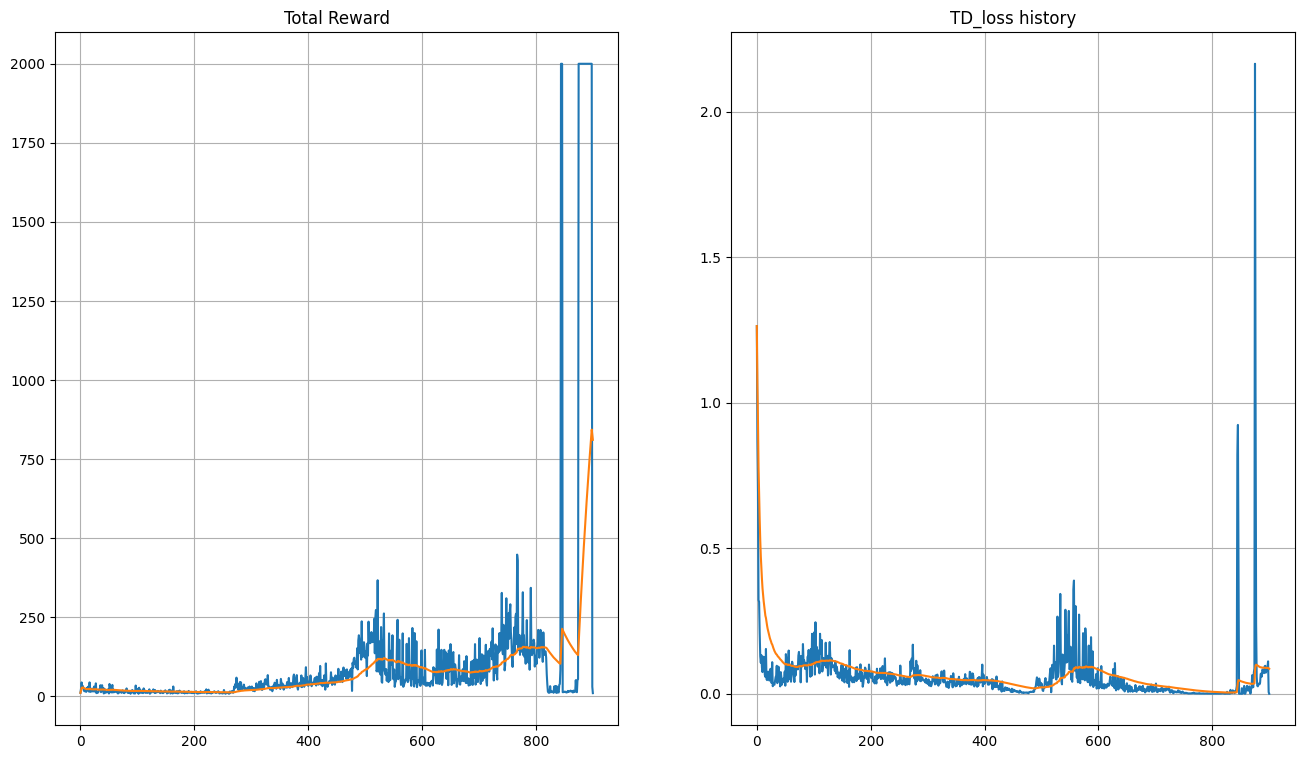

충분한 보상: 1526.08
학습종료


In [35]:
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

reward_record, TDloss_record = [], []
cnt = 0

for ep in range(max_episode):
    done = False
    state = env.reset()
    
    total_reward = 0
    mean_episode_TD = 0
    while True:
        torch_state = torch.FloatTensor(state)
        qvalues = train_agent(torch.unsqueeze(torch_state,0)) 
        action = train_agent.get_actions(qvalues)
        
        next_state,reward,done,_ = env.step(action[0])
        replay_buffer.add(state,action[0],reward,next_state,done)
        
        batch_sample = replay_buffer.sample(batch_size)
        loss = DDQN_TD_loss(batch_sample,train_agent,target_agent,env,gamma=gamma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mean_episode_TD += loss.item()
        total_reward += reward
        
        if cnt % model_update_period == 0:
            target_agent.load_state_dict(train_agent.state_dict())
            
        if done:
            mean_episode_TD /= cnt    
            TDloss_record.append(mean_episode_TD)
            reward_record.append(total_reward)
            break
        
        # 업데이트
        state = next_state
        train_agent.epsilon = epsilon_decay(ep,eps_max=1,eps_min=0.05,eps_decay=200)
        # target network update
        #or A_param, B_param in zip(train_agent1.parameters(), train_agent2.parameters()):
        #   A_param.data.copy_(tau * B_param + (1 - tau) * A_param)
        cnt += 1
    
    if ep % 50 == 0:
        clear_output(True)
        print(f'{ep}번째 에피소드 결과')
        print(f'Epsilon: {train_agent.epsilon}')
        print(f'최근 50 에피소드 보상평균 = {np.mean(reward_record[-50:])}')
        print(f'최근 50 에피소드 TD오차 = {np.mean(TDloss_record[-50:])}')
        
        plt.figure(figsize=[16, 9])
        
        plt.subplot(1,2,1)
        plt.title("Total Reward")
        plt.plot(reward_record)
        plt.plot(moving_average(reward_record))
        plt.grid()
        
        plt.subplot(1,2,2)
        plt.title("TD_loss history")
        plt.plot(TDloss_record)
        plt.plot(moving_average(TDloss_record))
        plt.grid()
        
        plt.show()
    
    if np.mean(reward_record[-50:]) >= 1500:
        print(f"충분한 보상: {np.mean(reward_record[-50:])}")
        print(f"학습종료")
        break

In [36]:
# 비디오를 저장해보겠습니다.
torch.save(train_agent,'./ckpt/CartPole/DDQN_CartPole_bestmodel.pth')
#train_agent = torch.load('./ckpt/CartPole/DDQN_CartPole_bestmodel.pth')

In [37]:
import gym.wrappers

def record(initial_state,agent,env,vid):
    state = initial_state
    sum_rewards = 0

    while True:
        vid.capture_frame()
        #env.render()
        torch_state = torch.FloatTensor(state)
        qvalues = train_agent(torch.unsqueeze(torch_state,0))
        action = train_agent.get_actions(qvalues)

        next_state,reward,done,_ = env.step(action[0])
        
        state = next_state
        sum_rewards += reward
        if done:
            break
    vid.close()
    return sum_rewards

env = gym.make('CartPole-v0')
env._max_episode_steps=2000
vid = gym.wrappers.monitoring.video_recorder.VideoRecorder(env,path='./videos/CartPole/DDQN_CartPole_video.mp4')
vid.render_mode="rgb_array"
state = env.reset()
rewards = record(state,train_agent,env,vid)

/home/hyunseok.hwang/anaconda3/envs/torch/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/home/hyunseok.hwang/anaconda3/envs/torch/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:421: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(


In [38]:
from IPython.display import Video

Video('./videos/CartPole/DDQN_CartPole_video.mp4',embed=True,width=512, height=512)